# Analisi Dati taratura misuratori
Notebook per l'elaborazione dei dati provenienti da impianto MID o altri impianti di taratura.  
Include: normalizzazione, aggregazione, plotting e salvataggio risultati.

---

## Revisione & Note

- 0.1 - librerie seaborn  
- 0.2 - aggiunte funzioni per gestire più cartelle e più grafici, normalizzazione dei dati in ingresso
- 0.3 - modifica funzioni per processo automatico
- 0.4 - pulizia generale

### Commenti:
- ....

### TODO:
- [ ] I....

## 1. Import & Configurazione iniziale
Import dei pacchetti necessari e configurazioni generali (grafica, percorsi, ecc.).

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.ticker import ScalarFormatter
import numpy as np
import os
import glob
import seaborn as sns

## 2. Definizione delle funzioni
Funzioni per lettura dati, normalizzazione, aggregazione, plotting e salvataggio.

### Acquisizione

In [5]:
# === FUNZIONI ===

def read_csv_files(folder):
    # Carica tutti i file .csv nella cartella indicata
    raw_dataframes = {}
    for file_path in glob.glob(os.path.join(folder, '*.csv')):
        df = pd.read_csv(file_path, sep = ";",decimal=',')
        df = df.iloc[:-1]  # Rimuove ultima riga
        filename = os.path.basename(file_path)
        raw_dataframes[filename] = df
    return raw_dataframes

def compute_std_limits(q_ref_range):
    # Definisce i limiti di accettazione secondo curva del tipo e_max=offset+% reading
    area = np.pi * (DN / 1000 / 2) ** 2  # in m^2
    q_offset = offset_error * area * 3600  # mm/s -> m3/h
    e_max = q_offset + reading_error * q_ref_range
    e_min = -e_max
    return e_min, e_max

def compute_oiml_limits(q_ref_range):
    # Definisce i limiti di accettazione secondo OIML, base a Q3, R, CL
    Q1 = Q3 / R
    Q2 = Q1 * 1.6
    Q4 = Q3 * 1.25

    e_max = np.piecewise(q_ref_range,
                         [q_ref_range < Q1,
                          (q_ref_range >= Q1) & (q_ref_range < Q2),
                          (q_ref_range >= Q2) & (q_ref_range <= Q4),
                          q_ref_range > Q4],
                         [np.nan,
                          (5 if CL == 2 else 3),
                          (2 if CL == 2 else 1),
                          np.nan])
    e_min = -e_max
    e_str = f'Q3={Q3} R{R} Class {CL}'
    return e_min, e_max, e_str

def get_subfolders(path='.', prefix=None):
    """
    Restituisce una lista dei nomi delle sottocartelle presenti nel percorso specificato,
    con possibilità di filtro per prefisso.

    Parametri:
        path (str): Percorso in cui cercare le sottocartelle. Default: cartella corrente.
        prefix (str, opzionale): Se specificato, include solo le cartelle che iniziano con questo prefisso.

    Ritorna:
        List[str]: Elenco delle sottocartelle filtrate.
    """

    folders = [name for name in os.listdir(path)
               if os.path.isdir(os.path.join(path, name))]

    if prefix:
        folders = [f for f in folders if f.startswith(prefix)]

    return folders

### Pulizia e aggregazione

In [6]:
def aggregate_data_norm(df):
    # aggrega i dati calcolando valori medi
    # gestisce in automatico diversi formati di input e normalizza output
    grouped = df.groupby('passo').agg(
        err_relative_mean=('err_relative', 'mean'),
        err_relative_std=('err_relative', 'std'),
        q_ref_mean=('q_ref', 'mean')
    ).reset_index()

    grouped = grouped.sort_values(by='q_ref_mean', ascending=False).reset_index(drop=True)

    # Avviso per q_ref_std > 1
    #if (grouped['q_ref_std'] > 1).any():
    #    print("Attenzione: std_q_ref superiore a 1 rilevato!")

    return grouped


def normalize_dataframe(df):
    """
    Normalizza il formato del DataFrame per l'analisi, estraendo e rinominando le colonne
    essenziali: 'passo', 'err_relative', 'q_ref'.

    Supporta nomi di colonne alternativi come 'errore_rel', 'errore', 'q', 'flow', ecc.

    Parametri:
        df (pd.DataFrame): Il DataFrame originale da normalizzare.

    Ritorna:
        pd.DataFrame: DataFrame contenente solo le colonne necessarie con nomi standardizzati.
    """
    col_map = {
        'passo': ['passo', 'P', 'Step'],
        'err_relative': ['err_relative', 'Ev /%', 'errore', 'rel_err', 'err'],
        'q_ref': ['mean_q_ref', 'Q_Ref', 'flow', 'portata', 'Qref']
    }

    normalized = pd.DataFrame()

    for standard_col, aliases in col_map.items():
        found = False
        for alias in aliases:
            if alias in df.columns:
                normalized[standard_col] = df[alias]
                found = True
                break
        if not found:
            raise ValueError(f"Colonna necessaria '{standard_col}' non trovata nel DataFrame.")

    return normalized


def clean_normalized_data(normalized, n):
    """
    ELIMINA DATI DI REGOLAZIONE
    Analizza i dataframe in 'normalized'. Se il numero di occorrenze di passo == 1
    è maggiore di 2 * n, rimuove le prime n righe dal dataframe.
    
    Parameters:
        normalized (dict): dizionario con {filename: dataframe normalizzato}
        n (int): numero di righe da rimuovere se condizione soddisfatta

    Returns:
        dict: nuovo dizionario con dataframe eventualmente aggiornati
    """
    updated = {}
    for fname, df in normalized.items():
        print(f"\nAnalizzando file: {fname}")
        #print(f"DEBUG Prime righe originali:\n{df.head()}")

        if 'passo' not in df.columns:
            print("ATTENZIONE: colonna 'passo' non trovata!")
            updated[fname] = df
            continue

        count_p1 = (df['passo'] == 1).sum()
        #print(f"DEBUG Numero di occorrenze passo == 1: {count_p1}")

        if count_p1 == 2 * n:
            print(f"Rimuovo le prime {n} righe da {fname}")
            df = df.iloc[n:]
        else:
            print(f"Nessuna modifica per {fname}")

        updated[fname] = df.reset_index(drop=True)
    return updated

### Plottaggio dati e automazione

In [7]:
def plot_aggregated_data(
    aggregated_dataframes,
    points=None,
    error_bars='y',
    error_mode='none',
    alpha_points=0.5,
    save_path=None,
    silent=False,
    meter_folder=None,
):
    """
    Plot dei dati aggregati da più file CSV.

    Parametri:
    - aggregated_dataframes: dict {nome_file: aggregated_dataframe} (obbligatorio)
    - points: dict {nome_file: raw_dataframe} oppure None (opzionale)
    - error_bars: 'y' per mostrare barre errore, 'n' per nasconderle
    - error_mode: 'none', 'oiml', 'std' (scegli tipo limiti da plottare)
    - alpha_points: trasparenza dei punti raw (default 0.5)
    - silent: 'y' per non mostrare grafici ma solo salvare png
    - save_path: cartella di salvataggio dei PNG, i file vengono nominati con il nome della cartella di provenienza
    

    Note:
    - Gli assi sono personalizzati: x in scala log, y con griglia ogni 1%.
    """
    sns.set(style='whitegrid', context='talk', palette='tab10')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Estrai range dinamico da tutti i file
    all_q_ref = pd.concat([
        df['q_ref_mean'] for df in aggregated_dataframes.values()
        if isinstance(df, pd.DataFrame) and 'q_ref_mean' in df.columns
    ])
    q_ref_min = max(all_q_ref.min() * 0.8, 0.001)
    q_ref_max = all_q_ref.max() * 1.2
    q_ref_range = np.logspace(np.log10(q_ref_min), np.log10(q_ref_max), 500)
    
                              
    #Limiti x OIML
    x_min = Q3 / R * 0.5
    x_max = Q3 * 1.25 * 1.2
    OIML_limits_range = np.logspace(np.log10(x_min), np.log10(x_max), 500)

    # Curve di errore
    if error_mode == 'STD':
        e_min, e_max = compute_std_limits(q_ref_range)
        ax.fill_between(q_ref_range, e_min, e_max, color='gray', alpha=0.2, label='Limite STD')
    elif error_mode == 'OIML':
        e_min, e_max, e_str = compute_oiml_limits(OIML_limits_range)
        ax.fill_between(OIML_limits_range, e_min, e_max, color='gray', alpha=0.2, label=f'OIML Limit - {e_str}')
    # else: niente limiti se 'none'

    # Dati aggregati + error bars
    colors = sns.color_palette('tab10')
    for idx, (filename, df_agg) in enumerate(aggregated_dataframes.items()):
        if not isinstance(df_agg, pd.DataFrame) or 'q_ref_mean' not in df_agg.columns:
            print(f"Attenzione: file '{filename}' saltato (dati aggregati non validi).")
            continue

        color = colors[idx % len(colors)]

        sns.lineplot(
            ax=ax,
            x='q_ref_mean', y='err_relative_mean',
            data=df_agg,
            label=filename,
            marker='o', markersize=5, linewidth=1.5, color=color
        )

        if error_bars == 'y':
            ax.errorbar(
                df_agg['q_ref_mean'], df_agg['err_relative_mean'],
                yerr=df_agg['err_relative_std'],
                fmt='none', ecolor='black', elinewidth=1, capsize=3
            )

        # Punti raw opzionali
        if points and filename in points:
            df_raw = points[filename]
            if isinstance(df_raw, pd.DataFrame) and {'q_ref', 'err_relative'}.issubset(df_raw.columns):
                ax.scatter(
                    df_raw['q_ref'], df_raw['err_relative'],
                    color=color, alpha=alpha_points, s=20, label=f'{filename} punti'
                )
            else:
                print(f"Attenzione: file '{filename}' saltato per punti raw (dati non validi).")

    # Personalizzazione assi
    ax.set_xscale('log') # Imposta la scala logaritmica sull'asse X
    # Applica ScalarFormatter per evitare la notazione scientifica
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    
    ax.set_xlabel('Q ref medio (m³/h)', fontsize=12, labelpad=15)
    ax.tick_params(axis='x', bottom=True, which='both', labelbottom=True, top=False, labeltop=False)
    ax.set_ylabel('Errore relativo medio', fontsize=12)
    title_string = meter_folder if meter_folder else "Accuracy"
    ax.set_title(f'{title_string} - Accuracy')
    ax.legend(fontsize=10, loc='upper right') #oppure loc=loc='best', 'upper left', 'lower right'....etc
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Centra l'asse X a y=0
    #ax.spines['bottom'].set_position(('data', 0))  # Sposta asse x a y=0
    ax.axhline(y=0, color='grey', linewidth=0.8) # Disegna asse a y=0

    # Minor tick su y
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    # Blocca range assi
    ax.set_xlim([x_min, x_max])
    #ax.set_ylim([-5.5, 5.5])

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        save_file = os.path.join(save_path, f"{os.path.basename(meter_folder) if meter_folder else 'plot'}.png")
        plt.savefig(save_file, dpi=300)
        print(f"Grafico salvato in: {save_file}")

    if silent == 'y':
        plt.close(fig)
        #print(f"YES silent: {silent}")
    else:
        plt.tight_layout()
        plt.show()
        #print(f"ELSE silent: {silent}")



In [8]:
def plot_matrix_aggregated_data(
    base_folder,
    folders,
    plot_params,
    q_reg_steps=None,
    save_path=None,
    ncols=2
):
    """
    Genera una matrice di grafici aggregati per le cartelle specificate.

    Parametri:
    - base_folder: percorso cartella base
    - folders: lista nomi cartelle da processare
    - plot_params: dizionario parametri per plot_aggregated_data
    - q_reg_steps: intero o None (numero righe da scartare)
    - save_path: percorso completo per salvataggio PNG (es. 'IMG/matrix.png')
    - ncols: numero colonne nella matrice di subplot
    """
    n_folders = len(folders)
    nrows = (n_folders + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 5))
    axes = np.array(axes).reshape(-1)  # Per indicizzazione piatta anche se 1 sola riga/colonna

    sns.set(style='whitegrid', context='talk', palette='tab10')

    for idx, folder_name in enumerate(folders):
        folder_path = os.path.join(base_folder, folder_name)
        raw_data = read_csv_files(folder_path)
        normalized_raw = {name: normalize_dataframe(df) for name, df in raw_data.items()}
        
        if q_reg_steps is not None:
            normalized = clean_normalized_data(normalized_raw, q_reg_steps)
        else:
            normalized = normalized_raw

        aggregated = {fname: aggregate_data_norm(df) for fname, df in normalized.items()}
        ax = axes[idx]
        
        # Riutilizza la logica della funzione esistente adattata a subplot
        valid_q_refs = [
            df['q_ref_mean'] for df in aggregated.values()
            if isinstance(df, pd.DataFrame) and 'q_ref_mean' in df.columns
        ]
        if not valid_q_refs:
            print(f"[WARN] Nessun dato valido per '{folder_name}', subplot ignorato.")
            ax.axis('off')
            continue
            
        all_q_ref = pd.concat(valid_q_refs)
        
        q_ref_min = max(all_q_ref.min() * 0.8, 0.001)
        q_ref_max = all_q_ref.max() * 1.2
        q_ref_range = np.logspace(np.log10(q_ref_min), np.log10(q_ref_max), 500)

        x_min = Q3 / R * 0.5
        x_max = Q3 * 1.25 * 1.2
        OIML_limits_range = np.logspace(np.log10(x_min), np.log10(x_max), 500)

        if plot_params.get('error_mode', 'none') == 'STD':
            e_min, e_max = compute_std_limits(q_ref_range)
            ax.fill_between(q_ref_range, e_min, e_max, color='gray', alpha=0.2, label='Limite STD')
        elif plot_params.get('error_mode', 'none') == 'OIML':
            e_min, e_max, e_str = compute_oiml_limits(OIML_limits_range)
            ax.fill_between(OIML_limits_range, e_min, e_max, color='gray', alpha=0.2, label=f'OIML Limit - {e_str}')

        colors = sns.color_palette('tab10')
        for i, (fname, df_agg) in enumerate(aggregated.items()):
            if not isinstance(df_agg, pd.DataFrame) or 'q_ref_mean' not in df_agg.columns:
                continue
            color = colors[i % len(colors)]
            ax.plot(df_agg['q_ref_mean'], df_agg['err_relative_mean'], label=fname,
                    marker='o', markersize=5, linewidth=1.5, color=color)

            if plot_params.get('error_bars', 'y') == 'y':
                ax.errorbar(df_agg['q_ref_mean'], df_agg['err_relative_mean'],
                            yerr=df_agg['err_relative_std'], fmt='none',
                            ecolor='black', elinewidth=1, capsize=3)

            if plot_params.get('points') == 'y' and fname in normalized:
                df_raw = normalized[fname]
                if isinstance(df_raw, pd.DataFrame) and {'q_ref', 'err_relative'}.issubset(df_raw.columns):
                    ax.scatter(df_raw['q_ref'], df_raw['err_relative'], color=color,
                               alpha=plot_params.get('alpha_points', 0.5), s=20,
                               label=f'{fname} punti')

        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.get_major_formatter().set_scientific(False)
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([-6, 6])
        ax.axhline(y=0, color='grey', linewidth=0.8)
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.set_title(folder_name)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Nascondi subplot vuoti
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300)
        print(f"[OK] Matrice salvata in: {save_path}")
        plt.show()
    else:
        plt.show()

In [9]:
# Funzione di elaborazione con salvataggio in cartella img/
def process_all_folders(base_folder, folders, plot_params, q_reg_steps=None):

    """
    Elabora in sequenza un insieme di cartelle contenenti file CSV.
    Per ciascuna cartella:
        1. Legge i file CSV
        2. Normalizza i dati
        3. (Opzionale) Elimina le prime righe in base ai passi di regolazione
        4. Aggrega i dati normalizzati
        5. Genera e salva il grafico (opzionalmente in modalità silenziosa)

    Parametri:
    - base_folder: stringa, percorso della cartella principale che contiene le sottocartelle con i dati CSV.
    - folders: lista di nomi di sottocartelle da processare (es. ['test1', 'test2']).
    - plot_params: dizionario con i parametri da passare alla funzione `plot_aggregated_data`, ad es.:
        {
            'error_bars': 'y',
            'error_mode': 'OIML',
            'alpha_points': 0.3,
            'silent': 'y'
        }
    - q_reg_steps: dizionario opzionale {filename: numero_di_step} da passare a `clean_normalized_data`.
                  Se None, non viene effettuata alcuna pulizia.

    Output:
    - Salva i grafici in formato PNG all’interno delle relative sottocartelle.
    """
    
    for folder_name in folders:
        folder_path = os.path.join(base_folder, folder_name)
        print(f'folder_path: {folder_path}')

        # Step 1: Lettura CSV
        raw_data = read_csv_files(folder_path)

        # Step 2: Normalizzazione
        normalized_raw = {name: normalize_dataframe(df) for name, df in raw_data.items()}

        # Step 3: Rimozione n righe iniziali se richiesto
        if q_reg_steps is not None:
            #print(f"[DEBUG] Pulizia dati: rimozione delle prime {q_reg_steps} righe")
            normalized = clean_normalized_data(normalized_raw, q_reg_steps)
            #print(f"[DEBUG] Pulizia completata: chiavi = {list(normalized.keys())}")
        else:
            #print("[DEBUG] Nessuna rimozione righe: uso normalizzati grezzi")
            normalized = normalized_raw  # <- assegna comunque qualcosa

        # Step 4: Aggregazione
        aggregated = {fname: aggregate_data_norm(df) for fname, df in normalized.items()}

        # Step 5: Plot
        save_img_path = os.path.join("IMG")
        plot_aggregated_data(
            aggregated_dataframes=aggregated,
            points=normalized,
            save_path=save_img_path,
            meter_folder=folder_path,
            **plot_params
        )

In [27]:
# Test only
plot_aggregated_data(aggregated,
                     points=normalized,
                     meter_folder=folder_path,
                     error_bars='y',
                     error_mode='OIML',
                     alpha_points=0.5,
                     save_path='IMG',
                     silent=False)

NameError: name 'aggregated' is not defined

## 3. Setup dei parametri globali
Impostazione dei percorsi di input/output, nomi cartelle, parametri grafici.

In [10]:
# Cartella principale = "." = cartella corrente
base_folder = "."

In [11]:
#Lista delle cartelle nella cartella corrente
folders = get_subfolders(prefix='R7K')
folders

['R7K00183',
 'R7K00185',
 'R7K00186',
 'R7K00187',
 'R7K00188',
 'R7K00189',
 'R7K00270',
 'R7K00272',
 'R7K00273']

In [12]:
# === PARAMETRI MISURATORI ===

DN = 150  # diametro di riferimento in mm

# Parametri STD
offset_error = 2  # mm/s
reading_error = 0.2 / 100  # % convertito in frazione

# Parametri OIML
Q3 = 400  # m3/h
R = 400
CL = 2  # classe di accuratezza: 1 o 2

# Modalità curva di errore ('STD' oppure 'OIML')
error_mode = 'OIML'

### Processo automatico

Genera tutti i grafici in formato png

In [13]:
plot_params={
    'error_bars': 'n',
    'error_mode': 'OIML',
    'alpha_points': 0.5,
    'silent': 'y'}

In [14]:
# Esecuzione
# Rivedere cartella di salvataggio da funzione process_all_folders
process_all_folders(base_folder, folders, plot_params, q_reg_steps=3)

folder_path: .\R7K00183

Analizzando file: ID9808.2025.R7K00183.R7K00183.csv
Rimuovo le prime 3 righe da ID9808.2025.R7K00183.R7K00183.csv

Analizzando file: ID9811.2025.R7K00183.R7K00183.csv
Nessuna modifica per ID9811.2025.R7K00183.R7K00183.csv

Analizzando file: ID9879.2025.R7K00183.R7K00183.csv
Nessuna modifica per ID9879.2025.R7K00183.R7K00183.csv
Grafico salvato in: IMG\R7K00183.png
folder_path: .\R7K00185

Analizzando file: ID9838.2025.R7K00185.R7K00185.csv
Nessuna modifica per ID9838.2025.R7K00185.R7K00185.csv

Analizzando file: ID9849.2025.R7K00185.R7K00185.csv
Nessuna modifica per ID9849.2025.R7K00185.R7K00185.csv

Analizzando file: ID9856.2025.R7K00185.R7K00185.csv
Nessuna modifica per ID9856.2025.R7K00185.R7K00185.csv
Grafico salvato in: IMG\R7K00185.png
folder_path: .\R7K00186

Analizzando file: ID9839.2025.R7K00186.R7K00186.csv
Nessuna modifica per ID9839.2025.R7K00186.R7K00186.csv

Analizzando file: ID9846.2025.R7K00186.R7K00186.csv
Nessuna modifica per ID9846.2025.R7K00

### Processo Manuale - per singolo meter

In [13]:
# Cartella contenente i file CSV
#folder_path = './'  # <- PER CARTELLA CORRENTE
folder_path = 'R7K00183'  # <- Modifica qui!

In [14]:
# Step 1: Leggi i file e carica in un dizionario di dataframes
raw_dataframes = read_csv_files(folder_path)

In [15]:
# normalizza dataframe dei dati in ingresso
normalized_raw = {fname: normalize_dataframe(df) for fname, df in raw_dataframes.items()}

In [16]:
# Pulisce dataframes da valori Qreg
# n=3 -> Ripetizioni di Qreg
normalized = clean_normalized_data(normalized_raw, n=3)


Analizzando file: ID9808.2025.R7K00183.R7K00183.csv
Rimuovo le prime 3 righe da ID9808.2025.R7K00183.R7K00183.csv

Analizzando file: ID9811.2025.R7K00183.R7K00183.csv
Nessuna modifica per ID9811.2025.R7K00183.R7K00183.csv

Analizzando file: ID9879.2025.R7K00183.R7K00183.csv
Nessuna modifica per ID9879.2025.R7K00183.R7K00183.csv


In [17]:
#pulizia manuale delle righe di regolazione
#df_clean = 'ID9885.2025.R7K00273.R7K00273.csv' # <- dataframe da pulire
#normalized[df_clean]=normalized[df_clean].iloc[3:]
#normalized

In [18]:
# Aggrega dati
aggregated = {fname: aggregate_data_norm(df) for fname, df in normalized.items()}

### Plotta Grafico Singolo

In [19]:
#plot_aggregated_data_sns(aggregated_dataframes, error_mode='OIML')
    plot_aggregated_data(aggregated,
                         points=normalized,
                         meter_folder=folder_path,
                         error_bars='y',
                         error_mode='OIML',
                         alpha_points=0.5,
                         save_path=None,
                        silent='n')

IndentationError: unexpected indent (3125159098.py, line 2)

### Plotta Matrice di grafici

In [20]:
#Parametri Grafico
plot_params2={
        "error_bars": "y",
        "error_mode": "OIML",
        "alpha_points": 0.5,
        "points": "n",
        "silent": "n"
    }


Analizzando file: ID9808.2025.R7K00183.R7K00183.csv
Rimuovo le prime 3 righe da ID9808.2025.R7K00183.R7K00183.csv

Analizzando file: ID9811.2025.R7K00183.R7K00183.csv
Nessuna modifica per ID9811.2025.R7K00183.R7K00183.csv

Analizzando file: ID9879.2025.R7K00183.R7K00183.csv
Nessuna modifica per ID9879.2025.R7K00183.R7K00183.csv

Analizzando file: ID9838.2025.R7K00185.R7K00185.csv
Nessuna modifica per ID9838.2025.R7K00185.R7K00185.csv

Analizzando file: ID9849.2025.R7K00185.R7K00185.csv
Nessuna modifica per ID9849.2025.R7K00185.R7K00185.csv

Analizzando file: ID9856.2025.R7K00185.R7K00185.csv
Nessuna modifica per ID9856.2025.R7K00185.R7K00185.csv

Analizzando file: ID9839.2025.R7K00186.R7K00186.csv
Nessuna modifica per ID9839.2025.R7K00186.R7K00186.csv

Analizzando file: ID9846.2025.R7K00186.R7K00186.csv
Nessuna modifica per ID9846.2025.R7K00186.R7K00186.csv

Analizzando file: ID9853.2025.R7K00186.R7K00186.csv
Nessuna modifica per ID9853.2025.R7K00186.R7K00186.csv

Analizzando file: ID

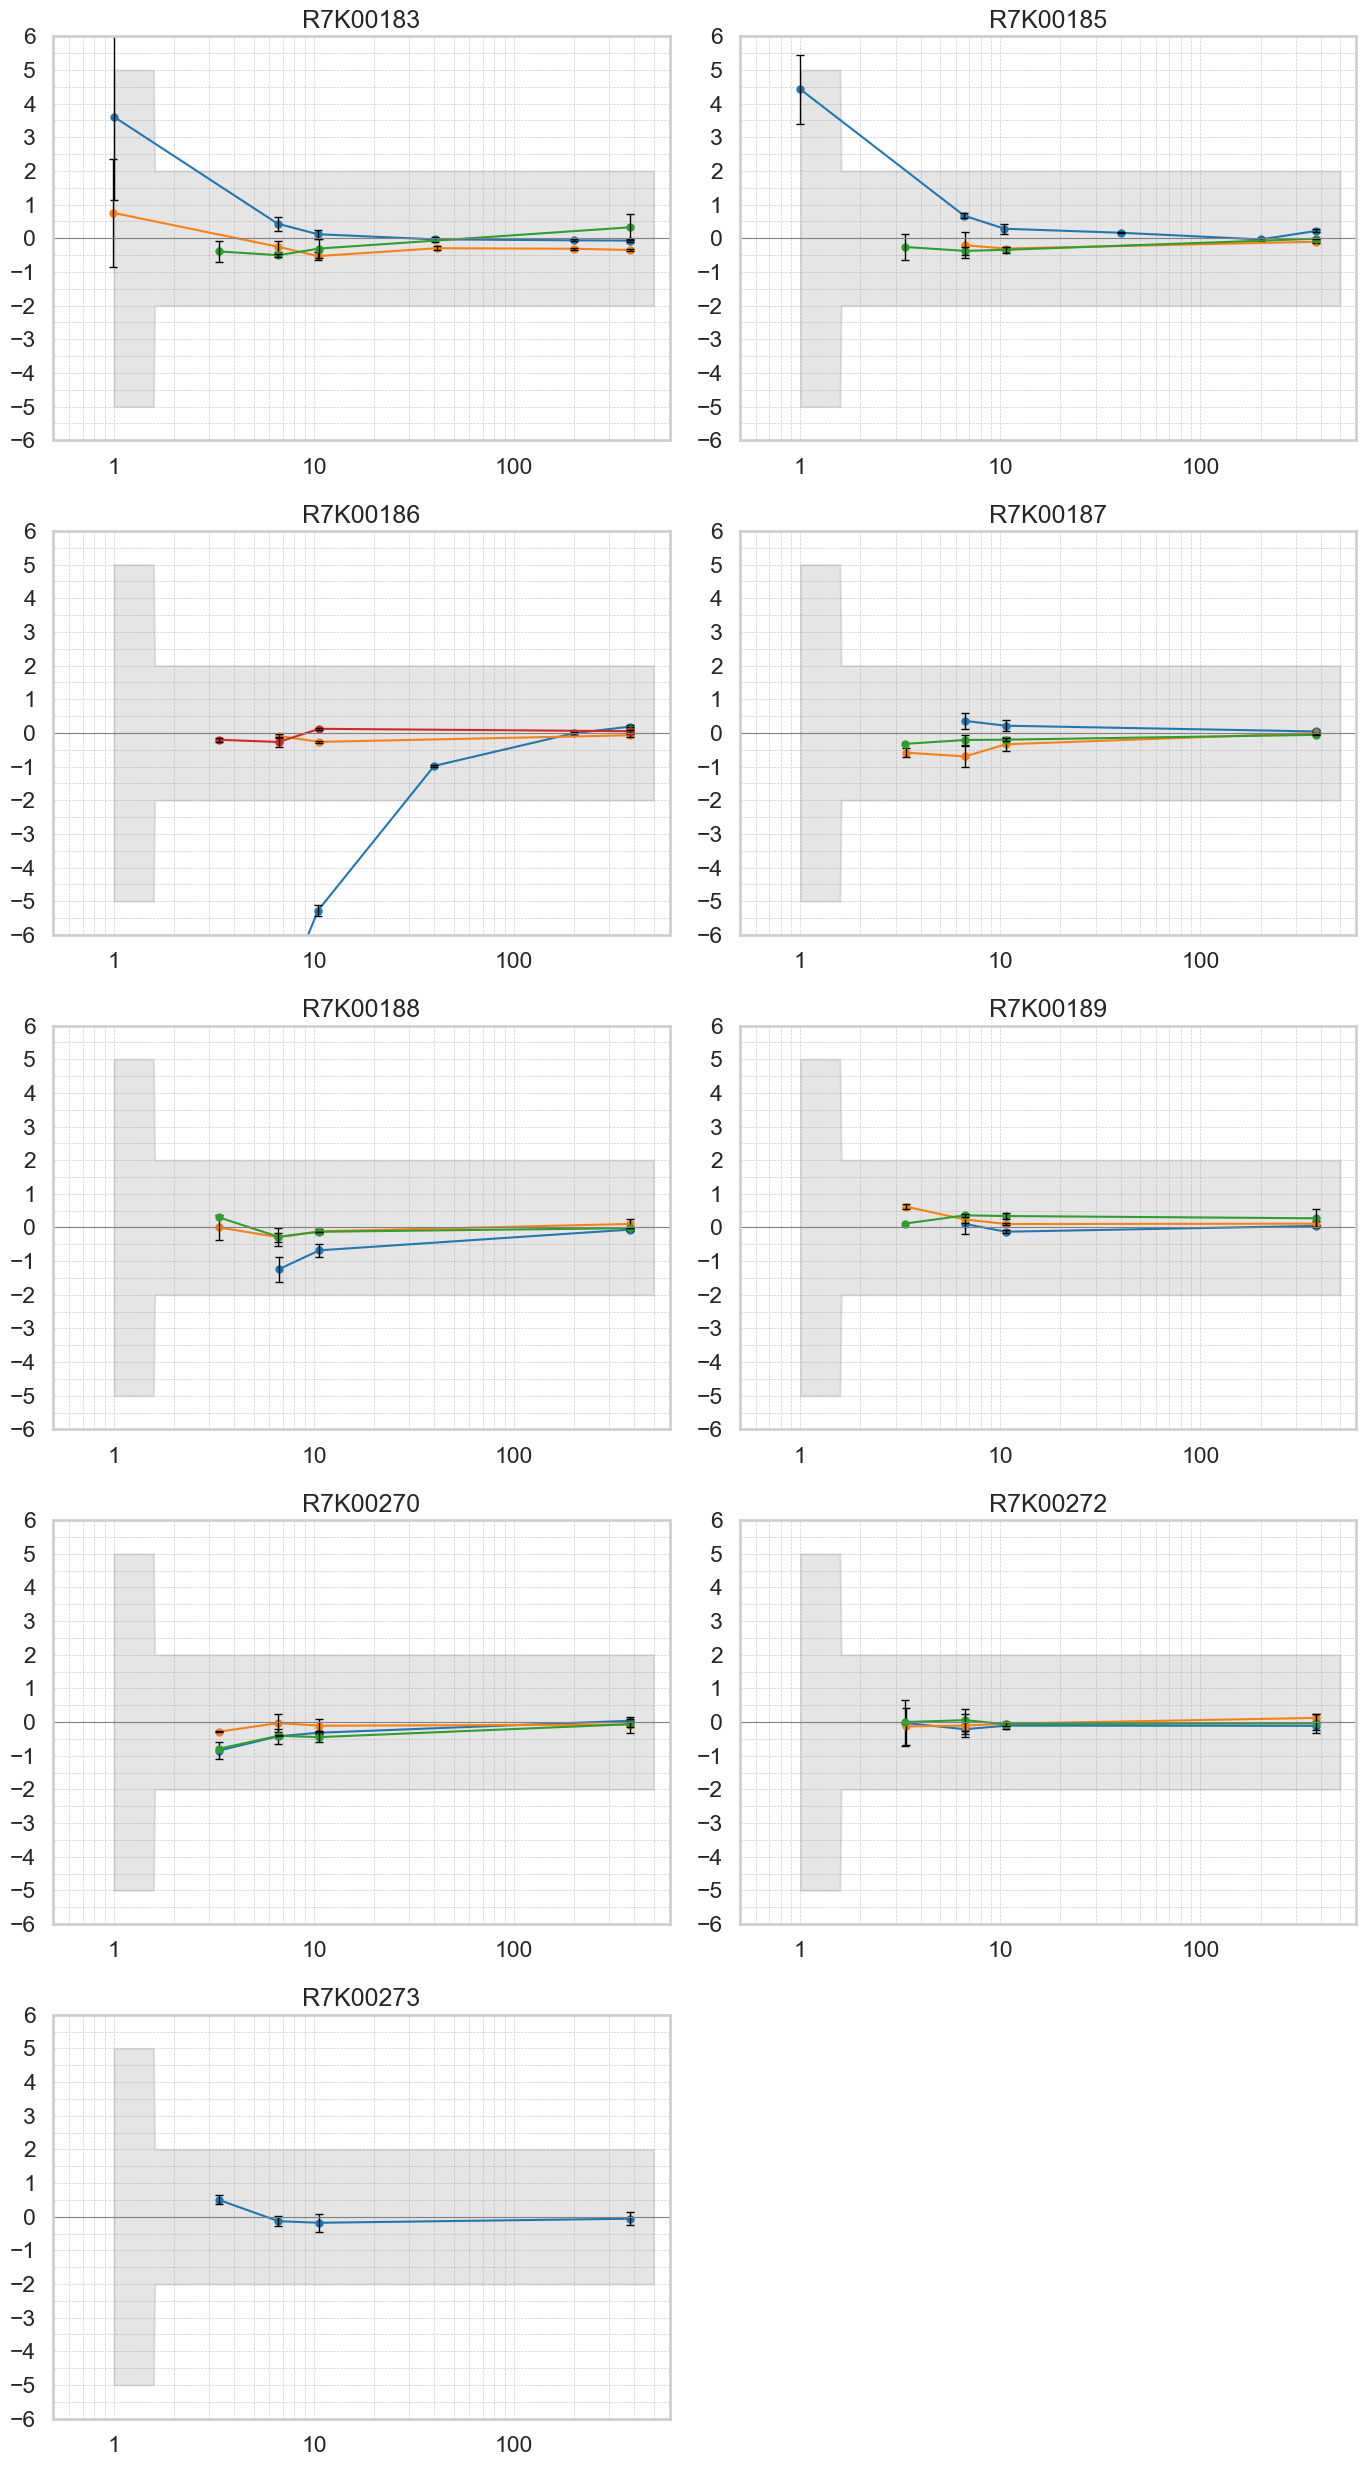

In [21]:
plot_matrix_aggregated_data(
    base_folder=".",
    folders=folders,
    plot_params=plot_params2,
    q_reg_steps=3,
    save_path="IMG/plot_matrix.png",
    ncols=2)